# Description

This notebook contains tools for debugging an individual `CcxtBroker` execution.

The notebook is responsible for aspects of the execution experiment run that are related to the correctness of the execution, as opposed to the analysis of the result:
- Consistency of logging
- Correctness in the submission of orders
- Consistency between trades and submitted orders
- Order time profiling

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

import core.config as cconfig
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-96a098b3-a465-4b0a-9ceb-e960ff99a80e.json'
INFO  # Git
  branch_name='CmTask8055_Fix_broker_debugging_notebook'
  hash='1f0694124'
  # Last commits:
    *   1f0694124 Sameep Pote Merge branch 'master' into CmTask8055_Fix_broker_debugging_notebook (64 seconds ago) Fri May 3 17:31:24 2024  (HEAD -> CmTask8055_Fix_broker_debugging_notebook, origin/CmTask8055_Fix_broker_debugging_notebook)
    |\  
    * | b89bc022a Sameep2808 Nits                                                              (75 seconds ago) Fri May 3 17:31:13 2024           
    | * ec2fcc859 Toma Jordania CmTask8033: load pre/post scheduled balances in master trading notebook (#8144) (22 minutes ago) Fri May 3 17:10:50 2024  (origin/master, origin/HEAD)
# Machine info
  system=Linux
  node name=ddbc6d300724
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 UTC 2024
  machine=x86_6

In [3]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
config = cconfig.get_notebook_config(config_file_name)
if config is None:
    system_log_dir = "/shared_data/toma/CmTask7440_1"

    config_dict = {"system_log_dir": system_log_dir}
    config = cconfig.Config.from_dict(config_dict)
print(config)

WARNING No config found, returning None
system_log_dir: /shared_data/toma/CmTask7440_1


In [4]:
log_dir = config["system_log_dir"]
ccxt_log_reader = obcccclo.CcxtLogger(log_dir)
#
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_trades_df = data["ccxt_trades"]
oms_child_order_df = data["oms_child_orders"]
oms_parent_order_df = data["oms_parent_orders"]
ccxt_fills = data["ccxt_fills"]

Loading '/shared_data/toma/CmTask7440_1/ccxt_child_order_responses':   0%|          | 0/66 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/oms_parent_orders':   0%|          | 0/4 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/child_order_fills/ccxt_trades':   0%|          | 0/20 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/oms_child_orders':   0%|          | 0/66 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/child_order_fills/oms_fills':   0%|          | 0/4 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/child_order_fills/ccxt_fills':   0%|          | 0/20 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/exchange_markets':   0%|          | 0/1 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/leverage_info':   0%|          | 0/1 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/positions':   0%|          | 0/1 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/balances':   0%|          | 0/4 [00:00<?, ?it/s]

Loading '/shared_data/toma/CmTask7440_1/reduce_only/ccxt_child_order_responses':   0%|          | 0/9 [00:00<?…

In [5]:
# Print the Broker config.
if "broker_config" in data:
    print(hprint.to_pretty_str(data["broker_config"]))
    universe_version = data["broker_config"]["universe_version"]
else:
    _LOG.warning("broker_config file not present in %s", log_dir)
    universe_version = None

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': [0.75, 0.7, 0.6, 0.8, 1.0],
                          'object_type': 'LimitPriceComputerUsingVolatility'},
 'log_dir': '/shared_data/toma/CmTask7440_1',
 'raw_data_reader': 'RawDataReader',
 'secret_identifier': 'binance.preprod.trading.4',
 'stage': 'preprod',
 'universe_version': 'v7.4'}


In [6]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(log_dir)
print(experiment_config)

INFO  Loading config from /shared_data/toma/CmTask7440_1/system_config.output.values_as_strings.pkl
WARNING Config file /shared_data/toma/CmTask7440_1/system_config.output.values_as_strings.pkl does not exist
None


In [7]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '14026958314', 'symbol': 'GMTUSDT'...",14026958314,x-xcKtGhcu66801b2bf98753ea657bb7,1710364503515,2024-03-13T21:15:03.515Z,NaN,1710364503515,GMT/USDT:USDT,limit,GTC,False,False,sell,0.3710,None,154.0,0.0,NaN,0.0,154.0,open,None,[],[],None,None,None,1710364503515,2024-03-13 21:15:03.515000+00:00
1,"{'orderId': '14026965713', 'symbol': 'GMTUSDT'...",14026965713,x-xcKtGhcud8b733a473996b1395e30f,1710364562812,2024-03-13T21:16:02.812Z,NaN,1710364562812,GMT/USDT:USDT,limit,GTC,False,False,sell,0.3708,None,154.0,0.0,NaN,0.0,154.0,open,None,[],[],None,None,None,1710364562812,2024-03-13 21:16:02.812000+00:00
2,"{'orderId': '14026996687', 'symbol': 'GMTUSDT'...",14026996687,x-xcKtGhcu432ba7e267baeaa6b0b56e,1710364802783,2024-03-13T21:20:02.783Z,NaN,1710364802783,GMT/USDT:USDT,limit,GTC,False,False,buy,0.3703,None,135.0,0.0,NaN,0.0,135.0,open,None,[],[],None,None,None,1710364802783,2024-03-13 21:20:02.783000+00:00


## Child order responses

In [8]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    56 non-null     object             
 1   order                   56 non-null     int64              
 2   client_order_id         56 non-null     object             
 3   timestamp               56 non-null     int64              
 4   datetime                56 non-null     object             
 5   last_trade_timestamp    2 non-null      float64            
 6   lastUpdateTimestamp     56 non-null     int64              
 7   symbol                  56 non-null     object             
 8   order_type              56 non-null     object             
 9   time_in_force           56 non-null     object             
 10  post_only               56 non-null     bool               
 11  reduce_only             56 non-null     bool   

## Child orders

In [9]:
oms_child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 14 to 101
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   creation_timestamp         66 non-null     datetime64[ns, UTC]
 1   asset_id                   66 non-null     int64              
 2   type_                      66 non-null     object             
 3   start_timestamp            66 non-null     datetime64[ns, UTC]
 4   end_timestamp              66 non-null     datetime64[ns, UTC]
 5   curr_num_shares            66 non-null     float64            
 6   diff_num_shares            66 non-null     float64            
 7   tz                         66 non-null     object             
 8   extra_params               66 non-null     object             
 9   volatility_multiple        66 non-null     float64            
 10  wave_id                    66 non-null     int64              
 11  num_data_po

In [10]:
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14,2024-03-13 21:15:00.315428+00:00,1030828978,limit,2024-03-13 21:15:00.315428+00:00,2024-03-13 21:16:00+00:00,0.0,-154.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,100,2024-03-13 21:14:59.279000+00:00,2024-03-13 21:14:59.752663+00:00,2024-03-13 21:14:59.719009+00:00,3309.0,15897.0,587,24.494897,0.000268,7.219982,0.3708,0.000268,7.218035,0.3709,0.000268,0.37085,7.219009,0.0001,2.696508,2.677169,0.3710,14026958314,14,1
22,2024-03-13 21:16:02.635785+00:00,1030828978,limit,2024-03-13 21:16:02.635785+00:00,2024-03-13 21:17:00+00:00,0.0,-154.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.70,1,115,2024-03-13 21:16:02.034000+00:00,2024-03-13 21:16:02.257798+00:00,2024-03-13 21:16:02.234037+00:00,19630.0,12910.0,594,24.494897,0.000266,7.181115,0.3706,0.000266,7.179178,0.3707,0.000266,0.37065,7.180146,0.0001,2.697963,2.661321,0.3708,14026965713,22,1
42,2024-03-13 21:20:02.566657+00:00,1030828978,limit,2024-03-13 21:20:02.566657+00:00,2024-03-13 21:21:00+00:00,-154.0,135.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,95,2024-03-13 21:20:01.762000+00:00,2024-03-13 21:20:01.953194+00:00,2024-03-13 21:20:01.915407+00:00,2998.0,34217.0,589,24.494897,0.000378,10.201470,0.3705,0.000378,10.198718,0.3706,0.000378,0.37055,10.200094,0.0001,2.698691,3.779645,0.3703,14026996687,42,1


### Extract the OMS parent order ID

In [11]:
oms_child_order_df["parent_order_id"] = oms_child_order_df["extra_params"].apply(
    lambda x: x["oms_parent_order_id"]
)
oms_child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num,parent_order_id
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14,2024-03-13 21:15:00.315428+00:00,1030828978,limit,2024-03-13 21:15:00.315428+00:00,2024-03-13 21:16:00+00:00,0.0,-154.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,100,2024-03-13 21:14:59.279000+00:00,2024-03-13 21:14:59.752663+00:00,2024-03-13 21:14:59.719009+00:00,3309.0,15897.0,587,24.494897,0.000268,7.219982,0.3708,0.000268,7.218035,0.3709,0.000268,0.37085,7.219009,0.0001,2.696508,2.677169,0.3710,14026958314,14,1,4
22,2024-03-13 21:16:02.635785+00:00,1030828978,limit,2024-03-13 21:16:02.635785+00:00,2024-03-13 21:17:00+00:00,0.0,-154.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.70,1,115,2024-03-13 21:16:02.034000+00:00,2024-03-13 21:16:02.257798+00:00,2024-03-13 21:16:02.234037+00:00,19630.0,12910.0,594,24.494897,0.000266,7.181115,0.3706,0.000266,7.179178,0.3707,0.000266,0.37065,7.180146,0.0001,2.697963,2.661321,0.3708,14026965713,22,1,4
42,2024-03-13 21:20:02.566657+00:00,1030828978,limit,2024-03-13 21:20:02.566657+00:00,2024-03-13 21:21:00+00:00,-154.0,135.0,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.75,0,95,2024-03-13 21:20:01.762000+00:00,2024-03-13 21:20:01.953194+00:00,2024-03-13 21:20:01.915407+00:00,2998.0,34217.0,589,24.494897,0.000378,10.201470,0.3705,0.000378,10.198718,0.3706,0.000378,0.37055,10.200094,0.0001,2.698691,3.779645,0.3703,14026996687,42,1,32


In [12]:
# Check how many child orders are generated per parent_order_id.
oms_child_order_df["parent_order_id"].value_counts().value_counts()

count
1    21
2    11
5     4
3     1
Name: count, dtype: int64

### Check the error messages in non-submitted orders.

In [13]:
# Select the OMS child orders with no CCXT ID and check their error messages.
not_submitted_oms_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] == -1
]
print(
    f"Number of not submitted OMS child orders={not_submitted_oms_child_order_df.shape[0]} \
    out of total orders={oms_child_order_df.shape[0]}"
)

Number of not submitted OMS child orders=10     out of total orders=66


In [14]:
# Extract all error messages from unsubmitted orders.
not_submitted_oms_child_order_df["error_msg"] = not_submitted_oms_child_order_df[
    "extra_params"
].apply(lambda x: x["error_msg"])

In [15]:
# Display error messages grouped by symbol.
# Get the universe to map asset_id's.
universe = ivcu.get_vendor_universe(
    "CCXT", "trade", version=universe_version, as_full_symbol=True
)
asset_id_to_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(universe)
not_submitted_oms_child_order_df[
    "full_symbol"
] = not_submitted_oms_child_order_df["asset_id"].map(asset_id_to_symbol_mapping)
# Get value counts of error messages.
error_msg = not_submitted_oms_child_order_df.groupby("full_symbol")[
    "error_msg"
].value_counts()
error_msg

full_symbol        error_msg                                                                                                   
binance::BTC_USDT  binance {"code":-4164,"msg":"Order's notional must be no smaller than 100 (unless you choose reduce only)."}    10
Name: count, dtype: int64

### Check the buy and sell orders with max notional

In [16]:
oms_child_order_notionals = (
    oms_child_order_df["diff_num_shares"] * oms_child_order_df["limit_price"]
)
max_sell_notional = oms_child_order_notionals[oms_child_order_notionals < 0].min()
max_buy_notional = oms_child_order_notionals[oms_child_order_notionals > 0].max()
_LOG.info(
    "Max sell notional: %s\nMax buy notional: %s",
    max_sell_notional,
    max_buy_notional,
)

INFO  Max sell notional: -82.511
Max buy notional: 95.27539999999999


## Parent orders

In [17]:
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2024-03-13 21:15:00+00:00,1464553467,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,0.015441,UTC,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s..."
1,2024-03-13 21:15:00+00:00,1467591036,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,0.001160,UTC,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s..."
2,2024-03-13 21:15:00+00:00,4516629366,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,-103.655672,UTC,"{'ccxt_symbol': 'SAND/USDT:USDT', 'stats': {'_..."


In [18]:
# Extract `ccxt_id` of child orders into a separate column.
oms_parent_order_df["child_order_ccxt_ids"] = oms_parent_order_df[
    "extra_params"
].apply(lambda x: x["ccxt_id"])
oms_parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,child_order_ccxt_ids
order_id,,,,,,,,,,
0,2024-03-13 21:15:00+00:00,1464553467,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,0.015441,UTC,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s...",[8389765661645699199]
1,2024-03-13 21:15:00+00:00,1467591036,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,0.001160,UTC,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s...",[]
2,2024-03-13 21:15:00+00:00,4516629366,price@twap,2024-03-13 21:15:00+00:00,2024-03-13 21:20:00+00:00,0.0,-103.655672,UTC,"{'ccxt_symbol': 'SAND/USDT:USDT', 'stats': {'_...","[15696233182, 15696237860]"


In [19]:
# Check how many child orders per parent order were successfully submitted.
# A value between maximum expected and 0 can mean that some child orders
# could not get through, while otherwise being well-formed.
# A value of 0 means that the parent order had an issue, e.g.
# having a notional that made all child orders below a minimum.
oms_parent_order_df["submitted_child_order_num"] = oms_parent_order_df[
    "child_order_ccxt_ids"
].str.len()
oms_parent_order_df["submitted_child_order_num"].value_counts()

submitted_child_order_num
1    21
2    11
0     5
5     2
3     1
Name: count, dtype: int64

## Trades

In [20]:
ccxt_trades_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2024-03-13 21:15:04.685000+00:00 to 2024-03-13 21:31:07.311000+00:00
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         33 non-null     datetime64[ns, UTC]
 1   datetime          33 non-null     datetime64[ns, UTC]
 2   symbol            33 non-null     object             
 3   asset_id          33 non-null     int64              
 4   id                33 non-null     int64              
 5   order             33 non-null     int64              
 6   side              33 non-null     object             
 7   takerOrMaker      33 non-null     object             
 8   price             33 non-null     float64            
 9   amount            33 non-null     float64            
 10  cost              33 non-null     float64            
 11  transaction_cost  33 non-null     float64            
 12  fe

### Verify that all trades correspond to logged child orders

In [21]:
# Verify that all trades have an associated order response.
# If the trade does not have an associated order, it means
# that a trade was executed that was not accounted for during the experiment.
all(ccxt_trades_df["order"].isin(ccxt_order_response_df["order"]))

True

In [22]:
# Verify that all trades have an associated 'ccxt_id' in OMS child orders.
# This verifies that there is a consistency between a CCXT order, OMS order and
# a CCXT trade. If a trade has no associated OMS child order `ccxt_id`, it means
# that an unexpected trade was executed, for example, by a different actor on the same account.
all(ccxt_trades_df["order"].isin(oms_child_order_df["ccxt_id"]))

True

### Check orders that do not correspond to any trades

In [23]:
# Existence of such orders is not necessarily a bug.
# It means that a given OMS child order was not filled.
child_orders_with_no_trades = ~oms_child_order_df["ccxt_id"].isin(
    ccxt_trades_df["order"]
)
child_orders_with_no_trades.sum()

33

### Check the correctness of trade amount

In [24]:
# If the traded amount is larger than the order, it means that an extra trade
# is executed and the order is filled for a larger amount.
# This can mean an accounting error on the exchange side.
trade_amount_by_order = ccxt_trades_df.groupby("order").agg({"amount": "sum"})
accepted_child_order_df = oms_child_order_df.loc[
    oms_child_order_df["ccxt_id"] != -1
]
trade_amount_by_order["child_order_amount"] = accepted_child_order_df.set_index(
    "ccxt_id"
)["diff_num_shares"].abs()

In [25]:
mask = (
    trade_amount_by_order["amount"] > trade_amount_by_order["child_order_amount"]
)
trade_amount_by_order.loc[mask]

,amount,child_order_amount
order,,


In [26]:
# Check the difference between the filled amount and the agg child order quantities.
trade_amount_by_order["diff"] = (
    trade_amount_by_order["child_order_amount"] - trade_amount_by_order["amount"]
)
trade_amount_by_order = trade_amount_by_order.rename(
    {"amount": "aggregated_trades_quantity"}, axis=1
)
trade_amount_by_order = trade_amount_by_order[
    ["child_order_amount", "aggregated_trades_quantity", "diff"]
]
trade_amount_by_order[trade_amount_by_order["diff"] > 0]

,child_order_amount,aggregated_trades_quantity,diff
order,,,


### Verify that CCXT IDs are equal in both child orders and responses

In [27]:
# Verify that we are not logging any CCXT orders that are not a part
# of the experiment, i.e. have no OMS order associated with it.
# We expect all retrieved responses to be a subset of CCXT IDs
# connected to the OMS child orders.
submitted_oms_orders_ccxt_ids = set(
    oms_child_order_df.loc[oms_child_order_df["ccxt_id"] != -1][
        "ccxt_id"
    ].unique()
)
ccxt_response_ids = set(ccxt_order_response_df["order"].unique())
ccxt_response_ids.issubset(submitted_oms_orders_ccxt_ids)

True

# Group trades by order

In [28]:
# Aggregate fills by order.
ccxt_trades_by_order = obccagfu.aggregate_fills_by_order(ccxt_trades_df)
ccxt_trades_by_order.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,
7837386385,2024-03-13 21:16:15.560000+00:00,2024-03-13 21:16:15.560000+00:00,2024-03-13 21:16:15.560000+00:00,2024-03-13 21:16:15.560000+00:00,STORJ/USDT:USDT,2425308589,0,1,0,1,0.0,78.0,0.0,78.0,0.0000,68.640,0.0,68.6400,0.8800,78.0,68.6400,0.013728,0.0000
7837409205,2024-03-13 21:22:08.851000+00:00,2024-03-13 21:22:08.851000+00:00,2024-03-13 21:22:08.851000+00:00,2024-03-13 21:22:08.851000+00:00,STORJ/USDT:USDT,2425308589,1,0,0,1,77.0,0.0,0.0,77.0,67.7215,0.000,0.0,67.7215,0.8795,77.0,67.7215,0.013544,0.0385
7837418608,2024-03-13 21:25:45.297000+00:00,2024-03-13 21:25:45.297000+00:00,2024-03-13 21:25:45.297000+00:00,2024-03-13 21:25:45.297000+00:00,STORJ/USDT:USDT,2425308589,0,1,0,1,0.0,60.0,0.0,60.0,0.0000,52.764,0.0,52.7640,0.8794,60.0,52.7640,0.010553,0.0000


# Time profiling for child orders

In [29]:
oms_child_order_df_unpacked = ccxt_log_reader.load_oms_child_order(
    unpack_extra_params=True, convert_to_dataframe=True
)

Loading '/shared_data/toma/CmTask7440_1/oms_child_orders':   0%|          | 0/66 [00:00<?, ?it/s]

In [30]:
# Get the timestamps of events for each child order
events = obccexqu.get_oms_child_order_timestamps(oms_child_order_df_unpacked)
events = events.sort_values(events.first_valid_index(), axis=1)

In [31]:
events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_twap_child_order::child_order.submission_started,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,,
14,2024-03-13 21:14:59.279000+00:00,2024-03-13 21:14:59.719009+00:00,2024-03-13 21:14:59.752663+00:00,2024-03-13 21:15:00.100670+00:00,2024-03-13 21:15:00.105419+00:00,2024-03-13 21:15:00.252335+00:00,2024-03-13 21:15:00.317290+00:00,2024-03-13 21:15:00.323924+00:00,2024-03-13 21:15:00.324591+00:00,2024-03-13 21:15:00.325466+00:00,2024-03-13 21:15:03.745700+00:00,2024-03-13 21:15:03.746101+00:00
22,2024-03-13 21:16:02.034000+00:00,2024-03-13 21:16:02.234037+00:00,2024-03-13 21:16:02.257798+00:00,2024-03-13 21:16:02.415087+00:00,2024-03-13 21:16:02.421648+00:00,2024-03-13 21:16:02.578193+00:00,2024-03-13 21:16:02.637816+00:00,2024-03-13 21:16:02.645038+00:00,2024-03-13 21:16:02.645917+00:00,2024-03-13 21:16:02.646758+00:00,2024-03-13 21:16:02.991889+00:00,2024-03-13 21:16:02.992346+00:00
42,2024-03-13 21:20:01.762000+00:00,2024-03-13 21:20:01.915407+00:00,2024-03-13 21:20:01.953194+00:00,2024-03-13 21:20:02.279070+00:00,2024-03-13 21:20:02.284222+00:00,2024-03-13 21:20:02.450700+00:00,2024-03-13 21:20:02.568802+00:00,2024-03-13 21:20:02.577409+00:00,2024-03-13 21:20:02.578222+00:00,2024-03-13 21:20:02.579475+00:00,2024-03-13 21:20:03.052330+00:00,2024-03-13 21:20:03.052778+00:00


In [32]:
# Get the difference between event timestamps.
time_delays = obccexqu.get_time_delay_between_events(events)

<Axes: ylabel='Time delay'>

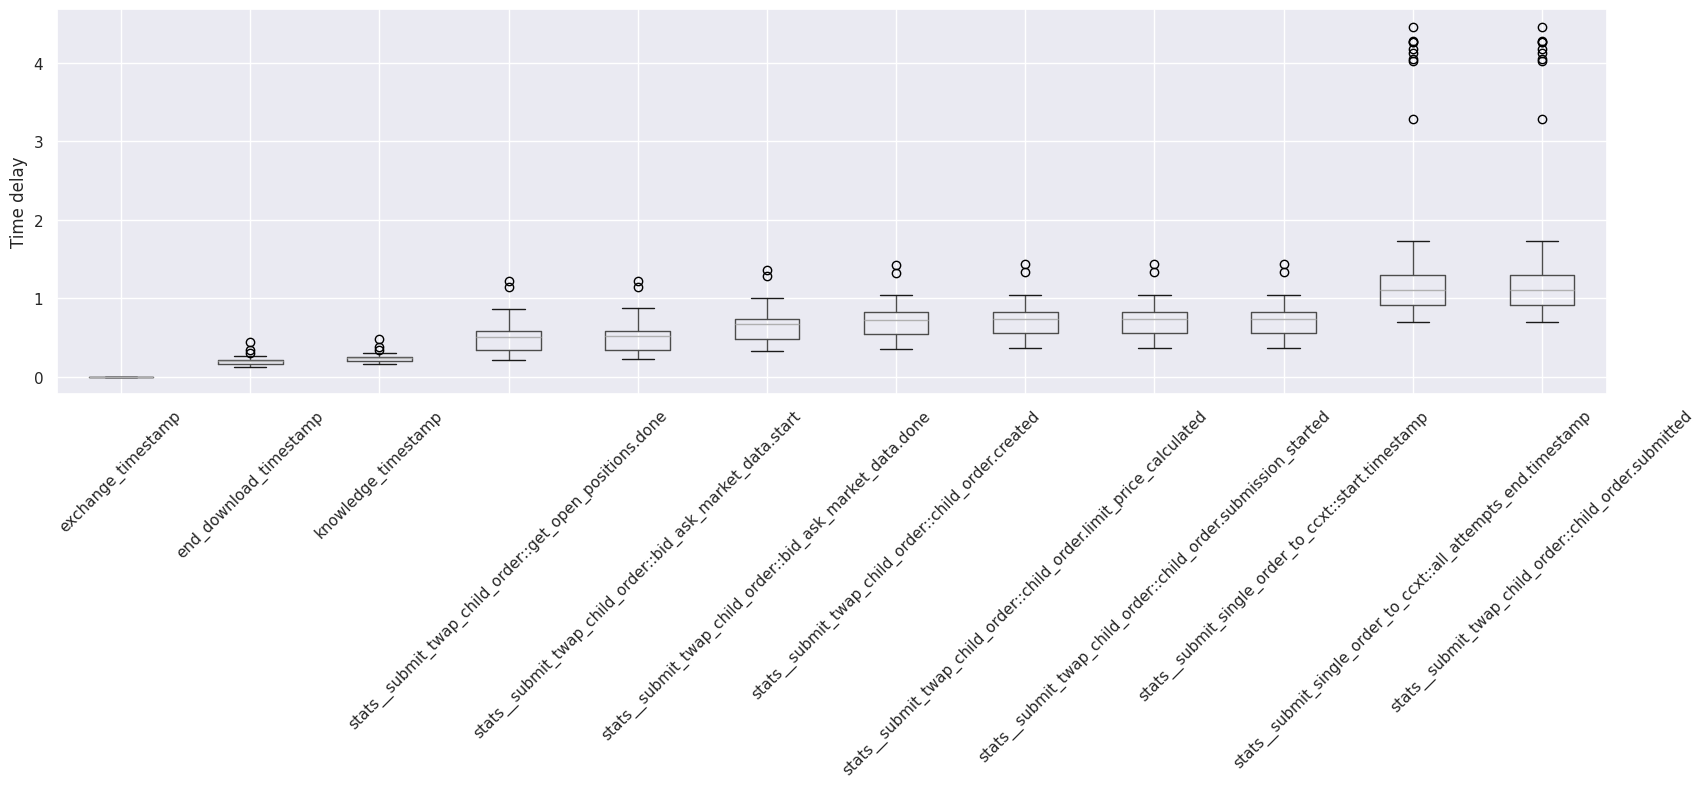

In [33]:
time_delays.boxplot(rot=45, ylabel="Time delay")

## Plot zero and non-zero waves separately

### Plot zero wave

In [34]:
# Since wave 0 begins execution later due to portfolio computation,
# we plot the time delays for it separately.
wave_zero = oms_child_order_df_unpacked[
    oms_child_order_df_unpacked["wave_id"] == 0
]
# Get the timestamps of events for each child order
wave_zero_events = obccexqu.get_oms_child_order_timestamps(wave_zero)
# Skip plotting wave 0 if it was not executed during the run.
plot_wave_zero = len(wave_zero_events) > 0
if plot_wave_zero:
    wave_zero_events = wave_zero_events.sort_values(
        wave_zero_events.first_valid_index(), axis=1
    )
else:
    _LOG.warning("Wave 0 was not executed during the run. Skipping plotting.")

In [35]:
wave_zero_events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_twap_child_order::child_order.submission_started,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,,
14,2024-03-13 21:14:59.279000+00:00,2024-03-13 21:14:59.719009+00:00,2024-03-13 21:14:59.752663+00:00,2024-03-13 21:15:00.100670+00:00,2024-03-13 21:15:00.105419+00:00,2024-03-13 21:15:00.252335+00:00,2024-03-13 21:15:00.317290+00:00,2024-03-13 21:15:00.323924+00:00,2024-03-13 21:15:00.324591+00:00,2024-03-13 21:15:00.325466+00:00,2024-03-13 21:15:03.745700+00:00,2024-03-13 21:15:03.746101+00:00
42,2024-03-13 21:20:01.762000+00:00,2024-03-13 21:20:01.915407+00:00,2024-03-13 21:20:01.953194+00:00,2024-03-13 21:20:02.279070+00:00,2024-03-13 21:20:02.284222+00:00,2024-03-13 21:20:02.450700+00:00,2024-03-13 21:20:02.568802+00:00,2024-03-13 21:20:02.577409+00:00,2024-03-13 21:20:02.578222+00:00,2024-03-13 21:20:02.579475+00:00,2024-03-13 21:20:03.052330+00:00,2024-03-13 21:20:03.052778+00:00
69,2024-03-13 21:25:01.751000+00:00,2024-03-13 21:25:01.986290+00:00,2024-03-13 21:25:02.013132+00:00,2024-03-13 21:25:02.289760+00:00,2024-03-13 21:25:02.295091+00:00,2024-03-13 21:25:02.427126+00:00,2024-03-13 21:25:02.490389+00:00,2024-03-13 21:25:02.500095+00:00,2024-03-13 21:25:02.500899+00:00,2024-03-13 21:25:02.501751+00:00,2024-03-13 21:25:02.912910+00:00,2024-03-13 21:25:02.913312+00:00


In [36]:
if plot_wave_zero:
    # Get the difference between event timestamps.
    time_delays = obccexqu.get_time_delay_between_events(wave_zero_events)

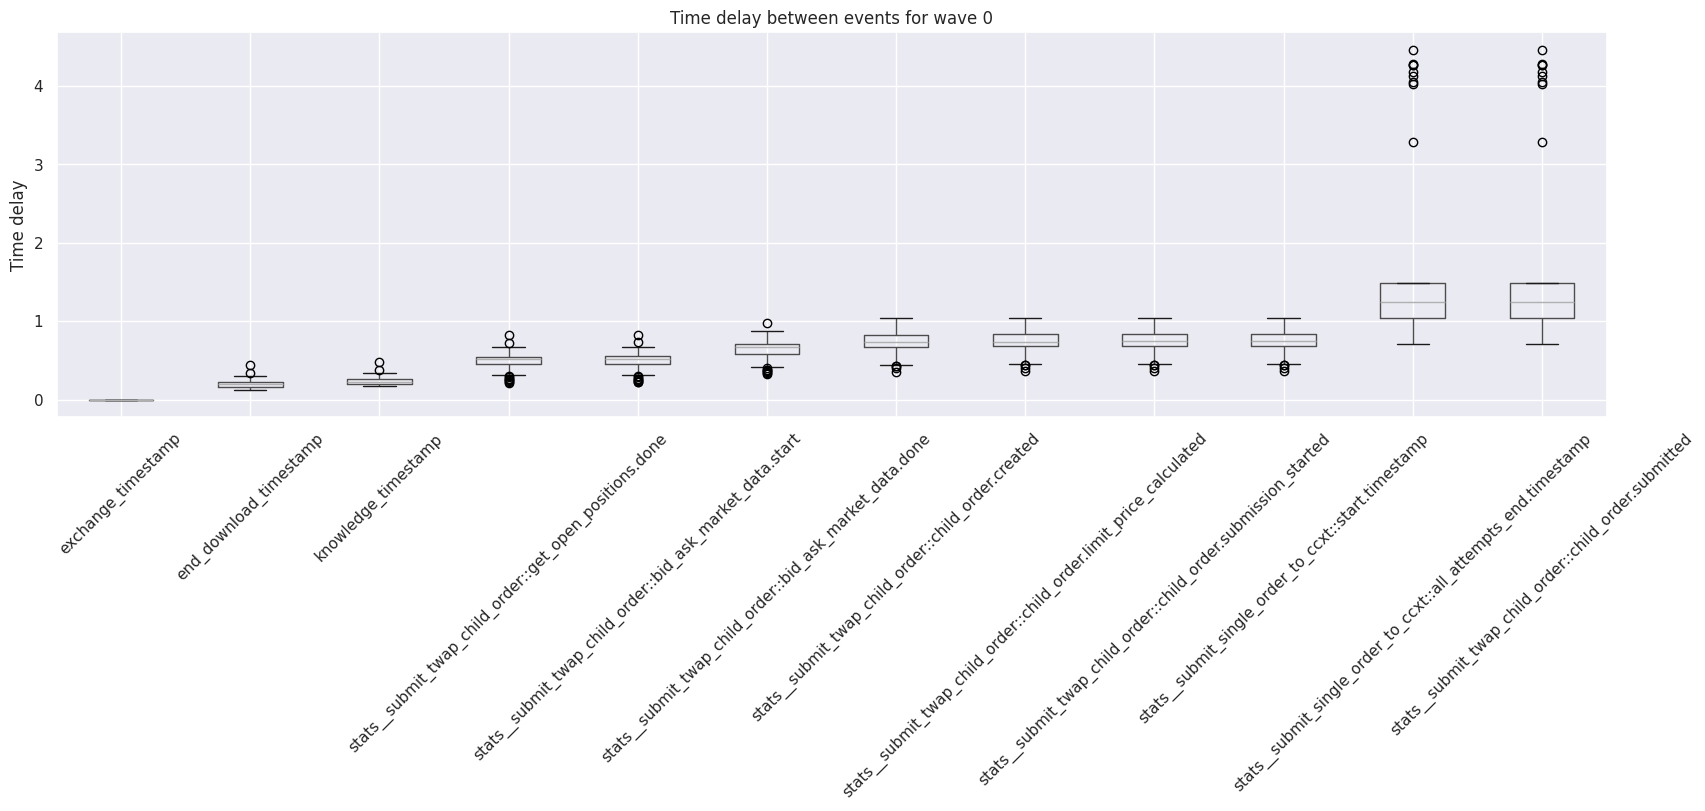

In [37]:
if plot_wave_zero:
    time_delays.boxplot(rot=45, ylabel="Time delay").set_title(
        "Time delay between events for wave 0"
    )

### Plot the rest of the waves

In [38]:
# Plot non-zero wave time to get the "average" time of the
# order submission, without computing portfolio and forecasts.
non_wave_zero_events = oms_child_order_df_unpacked[
    oms_child_order_df_unpacked["wave_id"] > 0
]
# Get the timestamps of events for each child order
non_wave_zero_events = obccexqu.get_oms_child_order_timestamps(
    non_wave_zero_events
)
non_wave_zero_events = non_wave_zero_events.sort_values(
    non_wave_zero_events.first_valid_index(), axis=1
)

In [39]:
non_wave_zero_events.head(3)

,exchange_timestamp,end_download_timestamp,knowledge_timestamp,stats__submit_twap_child_order::get_open_positions.done,stats__submit_twap_child_order::bid_ask_market_data.start,stats__submit_twap_child_order::bid_ask_market_data.done,stats__submit_twap_child_order::child_order.created,stats__submit_twap_child_order::child_order.limit_price_calculated,stats__submit_twap_child_order::child_order.submission_started,stats__submit_single_order_to_ccxt::start.timestamp,stats__submit_single_order_to_ccxt::all_attempts_end.timestamp,stats__submit_twap_child_order::child_order.submitted
order_id,,,,,,,,,,,,
22,2024-03-13 21:16:02.034000+00:00,2024-03-13 21:16:02.234037+00:00,2024-03-13 21:16:02.257798+00:00,2024-03-13 21:16:02.415087+00:00,2024-03-13 21:16:02.421648+00:00,2024-03-13 21:16:02.578193+00:00,2024-03-13 21:16:02.637816+00:00,2024-03-13 21:16:02.645038+00:00,2024-03-13 21:16:02.645917+00:00,2024-03-13 21:16:02.646758+00:00,2024-03-13 21:16:02.991889+00:00,2024-03-13 21:16:02.992346+00:00
75,2024-03-13 21:26:01.368000+00:00,2024-03-13 21:26:01.511824+00:00,2024-03-13 21:26:01.598693+00:00,2024-03-13 21:26:01.639513+00:00,2024-03-13 21:26:01.645855+00:00,2024-03-13 21:26:01.780954+00:00,2024-03-13 21:26:01.800893+00:00,2024-03-13 21:26:01.809152+00:00,2024-03-13 21:26:01.809983+00:00,2024-03-13 21:26:01.810822+00:00,2024-03-13 21:26:02.127125+00:00,2024-03-13 21:26:02.127680+00:00
80,2024-03-13 21:27:01.275000+00:00,2024-03-13 21:27:01.435649+00:00,2024-03-13 21:27:01.487012+00:00,2024-03-13 21:27:01.641370+00:00,2024-03-13 21:27:01.649927+00:00,2024-03-13 21:27:01.802070+00:00,2024-03-13 21:27:01.824849+00:00,2024-03-13 21:27:01.833733+00:00,2024-03-13 21:27:01.834487+00:00,2024-03-13 21:27:01.835415+00:00,2024-03-13 21:27:02.112472+00:00,2024-03-13 21:27:02.112988+00:00


In [40]:
# Get the difference between event timestamps.
time_delays = obccexqu.get_time_delay_between_events(non_wave_zero_events)

Text(0.5, 1.0, 'Time delay between events for waves >0')

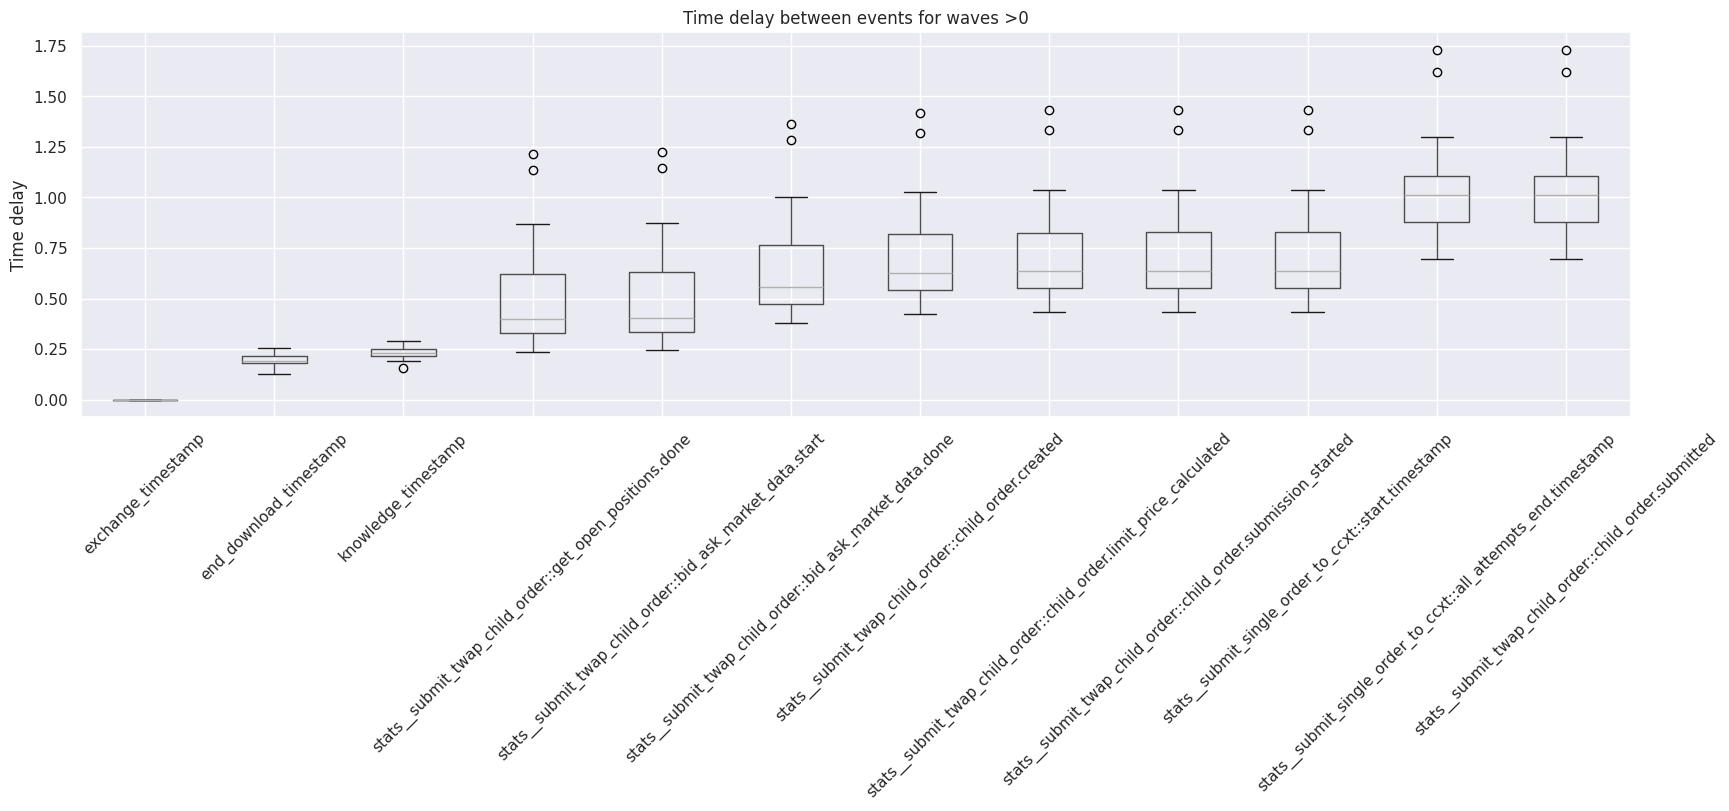

In [41]:
time_delays.boxplot(rot=45, ylabel="Time delay").set_title(
    "Time delay between events for waves >0"
)